<a href="https://colab.research.google.com/github/lk480/IIB_Project/blob/main/synthetic_stiv_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install perlin-noise
!pip install keras_cv
!pip install noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for noise: filename=noise-1.2.2-cp310-cp310-linux_x86_64.whl size=56278 sha256=9d5a423421553bb73ae4daacfd6c79c17abd1a479d63880cfd9814ff79c7267c
  Stored in directory: /root/.cache/pip/wheels/b2/01/64/ca2f6ed556c204d5ce2d3719a58757a5504aeb5525654692d0
Successfully built noise


In [ ]:
from PIL import Image
from perlin_noise import PerlinNoise
from scipy.ndimage import gaussian_filter
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

def generate_complex_perlin_noise(width, height, angle_degrees, scale, num_layers, octaves, persistence, lacunarity):

    noise = PerlinNoise()
    angle_radians = np.radians(angle_degrees)

    def perlin(x, y):
        # Generate Perlin noise value at a given (x, y) position
        return noise([x * np.cos(angle_radians) + y * np.sin(angle_radians)])

    shape = (height, width)
    world = np.zeros(shape)

    for i in range(height):
        for j in range(width):
            x = i / height * scale
            y = j / width * scale
            value = 0.0
            for layer in range(num_layers):
                layer_scale = scale / (2 ** layer)
                value += perlin(x/layer_scale, y/layer_scale) / (2 ** layer)

            value = (value + 1.0) / 2.0  # Normalize to [0, 1]
            amplitude = 0.01
            frequency = 0.01

            for _ in range(octaves):
              value += noise([x * frequency, y * frequency]) * amplitude
              amplitude *= persistence
              frequency *= lacunarity
            world[i][j] = value

    world = (world - np.min(world)) / (np.max(world) - np.min(world))  # Normalize to [0, 1]
    return world

def create_image_from_noise(noise_array):
    height, width = noise_array.shape
    image = Image.new('L', (width, height))

    for y in range(height):
        for x in range(width):
            value = noise_array[y][x]
            color_value = int(255 * value)
            image.putpixel((x, y), color_value)
    return image

In [ ]:
import os
import cv2
def create_training_set(lower_bound, upper_bound, num_samples):
  folder_path = '/content/drive/MyDrive/train_stiv_fft'
  if not os.path.exists(folder_path):
    os.makedirs(folder_path)
  for angle in tqdm(np.arange(lower_bound, upper_bound, 1)):
    for i in range(0,num_samples):
      perlin_noise = generate_complex_perlin_noise(width=128, height=128, angle_degrees=angle, scale=10, num_layers=10, octaves=5, persistence= 0.1, lacunarity=2.5)
      synthetic_stiv = create_image_from_noise(perlin_noise)
      stiv = np.array(synthetic_stiv)
      stiv = stiv/255.0
      fft_image = np.fft.fft2(stiv)
      fft_shifted = np.fft.fftshift(fft_image)
      magnitude_spectrum = np.abs(fft_shifted)
      magnitude_spectrum_log = np.log1p(magnitude_spectrum)
      normalized_image = 255 * (magnitude_spectrum_log - np.min(magnitude_spectrum_log)) / (np.max(magnitude_spectrum_log) - np.min(magnitude_spectrum_log))
      normalized_image = normalized_image.astype(np.uint8)
      plt.imshow(normalized_image)
      filename = f'stiv_fft_{angle}_{i}.jpg'
      full_path = os.path.join(folder_path, filename)
      cv2.imwrite(full_path, normalized_image)




100%|██████████| 30/30 [5:24:02<00:00, 648.09s/it]


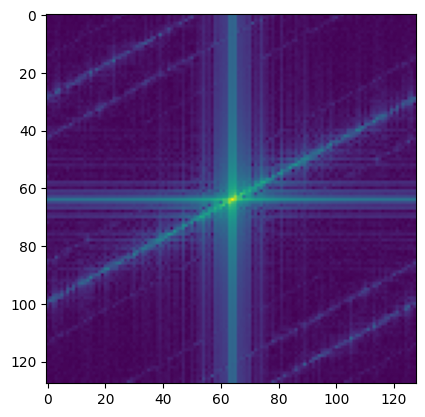

In [ ]:
create_training_set(lower_bound=90, upper_bound=120, num_samples=100)

In [ ]:
import tensorflow as tf
anisotropic_texture_path = '/content/drive/MyDrive/anisotropic_texture.png'
directional_texture_path = '/content/drive/MyDrive/directional_texture.png'

def load_data(image_path, size=(300,300)):
  #Load Image
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 3)
  image = tf.image.resize(image, size)
  image = tf.cast(image, tf.float32) / 255.0
  image = image.numpy()
  return image